In [4]:
import os
import json
import re
import PyPDF2

# Function to extract PDFs from a folder
def extract_pdfs_from_folder(pdf_folder):
    pdf_files = []
    for file_name in os.listdir(pdf_folder):
        if file_name.endswith('.pdf'):
            pdf_files.append(os.path.join(pdf_folder, file_name))
    return pdf_files

# Robust title extractor with multi-line handling and city/date filtering
def extract_title_from_pdf(pdf_text):
    lines = pdf_text.splitlines()

    skip_patterns = [
        r'Available at',
        r'www\.',
        r'^$',
        r'^DOI[:\s]',
        r'^http[s]?://',
        r'creativecommons.org',
    ]
    bad_title_patterns = [
        r'^\(?[A-Z][a-z]+, [A-Z]{2} \(',       # City, State ( e.g., Syracuse, NY (
        r'^\(?[A-Z][a-z]+ \d{1,2}(st|nd|rd|th)?\)?',  # Aug 6th
        r'^\(?\d{4}\)?$',                      # year
    ]
    stop_patterns = [
        r'^By ',
        r'\(\w{3,9} \d{1,2}',
        r'^\d{4} \d{1,2}:\d{2}',               # timestamps
    ]

    clean_lines = [line.strip() for line in lines if line.strip()]
    title_candidates = []

    for i in range(min(50, len(clean_lines))):
        line = clean_lines[i]
        if any(re.search(pat, line, re.IGNORECASE) for pat in skip_patterns):
            continue
        if any(re.search(pat, line.strip(), re.IGNORECASE) for pat in bad_title_patterns):
            continue
        if any(re.search(pat, line, re.IGNORECASE) for pat in stop_patterns):
            break
        if len(line.split()) < 2:
            continue
        title_candidates.append((i, line))

    # Step 1: Multi-line title merge
    for i, line in title_candidates:
        if i + 1 < len(clean_lines):
            next_line = clean_lines[i + 1].strip()
            full_title = f"{line} {next_line}"
            if 6 <= len(full_title.split()) <= 20 and not full_title.endswith('.'):
                return full_title

    # Step 2: Title right before "By"
    for idx, line in title_candidates:
        if idx + 1 < len(clean_lines) and clean_lines[idx + 1].lower().startswith("by "):
            return line

    # Step 3: Fallback to any decent candidate
    for _, line in title_candidates:
        if len(line.split()) >= 4:
            return line

    return "Unknown Title"

# Function to extract text from a PDF
def extract_text_from_pdf(pdf_file):
    try:
        pdf_reader = PyPDF2.PdfReader(pdf_file)
        pdf_text = ""
        for page_num in range(len(pdf_reader.pages)):
            page_text = pdf_reader.pages[page_num].extract_text()
            if page_text:
                pdf_text += page_text
        return pdf_text
    except KeyError as e:
        print(f"Error processing {pdf_file}: {e}")
        return None
    except Exception as e:
        print(f"Unexpected error processing {pdf_file}: {e}")
        return None

# Main script
pdf_folder = r"sample_data"
output_path = 'extracted_test_papers_new_rors.jsonl'

papers = []
pdf_files = extract_pdfs_from_folder(pdf_folder)

for pdf_file in pdf_files:
    text = extract_text_from_pdf(pdf_file)
    if text:
        title = extract_title_from_pdf(text)
        papers.append({"title": title, "content": text})
        print(f" {os.path.basename(pdf_file)} → Title: {title}")
    else:
        print(f" Failed to extract text from: {os.path.basename(pdf_file)}")

# Save output to JSONL
with open(output_path, 'w', encoding='utf-8') as f:
    for paper in papers:
        safe_text = json.dumps(paper, ensure_ascii=False).encode('utf-8', 'ignore').decode('utf-8')
        f.write(safe_text + "\n")

print(f"\n Extraction complete. Output saved to: {output_path}")


 Asynchronous Distributed Key Generation for Computationally-Secure Randomness, Consensus, and Threshold Signatures..pdf → Title: Secure Randomness, Consensus, and Threshold Signatures. Eleftherios Kokoris-Kogias†
 CapSpeaker Injecting Voices to Microphones via Capacitors.pdf → Title: CapSpeaker: Injecting Voices to Microphones via Capacitors Xiaoyu Ji
 Charting the Attack Surface of Trigger-Action IoT Platforms..pdf → Title: Charting the Atack Surface of Trigger-Action IoT Platforms Qi
 DeMiCPU_ Device Fingerprinting with Magnetic Signals Radiated by CPU..pdf → Title: DeMiCPU: Device Fingerprinting with Magnetic Signals Radiated by CPU
 EchoHand High Accuracy and Presentation Attack Resistant Hand Authentication on Commodity Mobile Devices.pdf → Title: EchoHand: High Accuracy and Presentation Attack Resistant Hand Authentication on Commodity Mobile Devices
 ECMO Peripheral Transplantation to Rehost Embedded Linux Kernels.pdf → Title: ECMO: Peripheral Transplantation to Rehost Embedded

In [15]:
def generate_all_metadata_prompt(task, paper, ack_section_presence=None):
    title = paper['title']
    content = paper['content']

    if task == "title":
        return f'''
        You are tasked with extracting the full title from the given paper titled "{title}".

        Guidelines:
        \t- The title is usually at the top of the first page or in the first section.
        \t- Extract the title in its entirety.

        Your response must be in the following JSON format:
        {{
            "title": "Title of the paper here"
        }}

        Here is the paper content:
        <Start of Paper Content>
        {content}
        <End of Paper Content>

        Your response: """
        '''

    elif task == "authors":
        return f'''
        You are tasked with extracting the list of authors from the paper titled "{title}".

        Guidelines:
        \t- The authors' names are typically listed directly below the title or in the header/footer.
        \t- Extract all authors, separated by commas.

        Your response must be in the following JSON format:
        {{
            "authors": "Comma-separated list of authors' names here"
        }}

        Here is the paper content:
        <Start of Paper Content>
        {content}
        <End of Paper Content>

        Your response: """
        '''
    elif task == "school_names":
        return f'''
        You are tasked with extracting the name(s) of academic institutions or organizations affiliated with the authors of the paper titled "{title}".

        Guidelines:
        \t- The school or institutional affiliations are usually listed below the authors' names or in the first page.
        \t- Extract **all** school names or affiliations mentioned.
        \t- Include universities, colleges, research institutions, or companies if provided.
        \t- Remove duplicates if the same institution is mentioned multiple times.

        Your response must be returned in the following JSON format:
        {{
            "school_names": ["University of California, Berkeley", "National University of Singapore"]
        }}

        Here is the paper content:
        <Start of Paper Content>
        {content}
        <End of Paper Content>

        Your response: """
        '''
    elif task == "affiliation_countries":
        return f'''
        You are tasked with extracting the country or countries where the authors or their affiliated institutions are based for the paper titled "{title}".

        Guidelines:
        \t- Country names are often listed after the institution name, or appear in the corresponding author information, address section, or footnotes.
        \t- Only look at the countries mentioned alongside author names, typically found at the top of the paper. Do not scan the entire document.
        \t- If a country is not explicitly stated but can be reliably inferred from a well-known institution (e.g., MIT → USA), include it.
        \t- Do not guess or hallucinate. If the country cannot be determined, return "null".
        \t- Classify research geography using ONLY the extracted countries.
        \t\t- "US_only":
        \t\t\t- All author affiliations are based in the United States.

        \t\t- "Non_US_only":
        \t\t\t- All author affiliations are based outside the United States.

        \t\t- "US_international_collaboration":
        \t\t\t- At least one U.S.-based affiliation AND at least one non-U.S.-based affiliation.

        \t\t- "International_collaboration":
        \t\t\t- Author affiliations include two or more non-U.S. countries and no U.S.-based affiliation.

        Your response must be in the following JSON format:
        {{
            "affiliation_countries": ["USA", "Germany"],
            "research_geography_category": ["US_only"]
        }}

        Here is the paper content:
        <Start of Paper Content>
        {content}
        <End of Paper Content>

        Your response: """
        '''

    # elif task == "conference":
    #     return f'''
        
    #     You are tasked with identifying the conference of publication for the paper titled "{title}".

    #     Guidelines:
    #     \t1- The conference name will always be one of the following:
    #     \t- "DFRWS USA"
    #     \t- "DFRWS Europe"
    #     \t- "DFRWS APAC"
        
    #     \t2- Read the paper carefully to determine which DFRWS conference it was published in.
        
    #     Your response must be in the following JSON format:
    #     {{
    #         "conference": "DFRWS USA"
    #     }}

    #     Here is the paper content:
    #     <Start of Paper Content>
    #     {content}
    #     <End of Paper Content>

    #     Your response: """
    #     '''

    elif task == "published_year":
        return f'''
        
        You are tasked with extracting the year of publication from the digital forensics paper titled "{title}".

        Guidelines:
        - The year is usually found near the conference name or in the paper's footer/header.

        Your response must be in the following JSON format:
        {{
            "year": "Year of publication here"
        }}

        Here is the paper content:
        <Start of Paper Content>
        {content}
        <End of Paper Content>

        Your response: """
        '''
    elif task == "ack_section_presence":
        
        return f'''
        You are tasked with determining whether the paper titled "{title}" contains an Acknowledgements section or any funding-related section.

        Guidelines:
        \t- Look for headings such as "Acknowledgements", "Acknowledgments", "Funding", "Support", "Financial Support", "Disclosure", or similar.
        \t- These sections typically appear near the end of the paper, but may also appear as a footnote on the first page.
        \t- Do not infer funding. Only report whether a section exists in the text.

        Your response must be in the following JSON format:
        
        {{
            "ack_or_funding_section_present": true,
            "section_headings_found": ["Acknowledgements"],
            "notes": "Short note about where it appears (e.g., end of paper, footnote on first page)."
        }}

        If no such section exists, return:
        {{
            "ack_or_funding_section_present": false,
            "section_headings_found": [],
            "notes": "No acknowledgements or funding-related section found."
        }}

        Here is the paper content:
        <Start of Paper Content>
        {content}
 `      <End of Paper Content>

        Your response: """
        '''
    
    elif task == "funding_entities":
        
        ack_json = json.dumps(ack_section_presence, ensure_ascii=False) if ack_section_presence is not None else "null"
        
        return f'''
        You are tasked with extracting funding-related information for the paper titled "{title}".
        
        You have already been provided with the result of a prior task that checked for the presence of an acknowledgements or funding-related section.
        Here is the acknowledgement section presence extracted earlier:
        
        {ack_json}
        Guidelines:
        \t- If "ack_or_funding_section_present" is false, do NOT extract funding information.
        \t\t- In this case, return null or empty values as specified below.
        \t- If "ack_or_funding_section_present" is true, extract funding information ONLY from the acknowledgements or funding-related section.
        \t- Do not scan the rest of the document.
        \t- Extract:
        \t\t- Funding agency or sponsor names (e.g., NSF, NIH, DOE, EU Horizon, national ministries, companies).
        \t\t-  Grant numbers, award numbers, contract numbers, or project IDs (if present).
        \t\t\t- Do not infer undisclosed funding. If nothing is stated, return empty lists.

        Your response must be in the following JSON format:
        {{
            "funding_agencies": ["National Science Foundation", "National Institutes of Health"],
            "award_or_contract_identifiers": ["NSF-1234567", "R01AA000000"],
            "support_type_mentions": ["institutional support", "industry sponsorship"]
        }}
        
        If no acknowledgements or funding-related section is present, return:
        {{
            "funding_agencies": [],
            "award_or_contract_identifiers": [],
            "support_type_mentions": "No acknowledgements or funding section present."
        }}

        Here is the paper content:
        <Start of Paper Content>
        {content}
        <End of Paper Content>

        Your response: """
        '''
    elif task == "funding_specificity":
        
        return f'''
        
        You are tasked with characterizing the specificity of any funding/disclosure statements in the paper titled "{title}".
        
        Guidelines:
        \t- This is descriptive only. Do NOT assess compliance or intent.
        \t- Use the following scale:
        \t\t- "High": agency/sponsor named AND at least one identifier (grant/contract/award number) OR detailed program name.
        \t\t- "Medium": agency/sponsor named but no identifier.
        \t\t- "Low": vague support mentioned (e.g., "supported by various sources", "thanks to sponsors") without naming.
        \t\t- "None": no funding/disclosure language found.
        \t\t- If unclear, return none.

        Your response must be in the following JSON format:
        {{
            "funding_disclosure_specificity": "High",
            "evidence_snippet": "Short excerpt (1-2 sentences) that supports the classification, or empty string if None."
        }}

        Here is the paper content:
        <Start of Paper Content>
        {content}
        <End of Paper Content>

        Your response: """
        '''


    else:
        raise ValueError("Invalid task")

        

In [16]:
# =========================
INPUT_JSONL_PATH = "extracted_test_papers_new_rors.jsonl"
OUTPUT_CSV_PATH  = "rors_sample_paper.csv"
OUTPUT_JSONL_PATH = "rors_sample_paper.jsonl"

tasks = [
    "title",
    "authors",
    "school_names",
    "affiliation_countries",     # supported as alias too
    "published_year",
    "ack_section_presence",
    "funding_entities",
    "funding_specificity"
]

# =========================
# LOAD API KEY
# =========================
load_dotenv("api_key.env")
client = OpenAI(api_key=os.environ.get("OPENAI_API_KEY"))

# =========================
# LOAD PAPERS
# =========================
def load_jsonl(path: str):
    papers = []
    with open(path, "r", encoding="utf-8") as f:
        for line_no, line in enumerate(f, start=1):
            line = line.strip()
            if not line:
                continue
            try:
                papers.append(json.loads(line))
            except json.JSONDecodeError as e:
                raise ValueError(f"Bad JSON on line {line_no} in {path}: {e}") from e
    return papers

papers = load_jsonl(INPUT_JSONL_PATH)
if not papers:
    raise ValueError(f"No papers found in {INPUT_JSONL_PATH}")

# =========================
# MAIN PROCESSOR
# =========================
def process_papers_for_tasks(papers, tasks):
    task_results = {}

    for i, paper in enumerate(papers):
        paper_title = paper["title"]
        print(f"Processing paper: {paper_title}")

        task_results[paper_title] = {}

        # store parsed ack_section_presence JSON to pass into funding_entities
        ack_presence_obj = None

        for task in tasks:
            user_prompt = generate_all_metadata_prompt(
                task,
                paper,
                ack_section_presence=ack_presence_obj
            )

            try:
                response = client.chat.completions.create(
                    model="gpt-5.2",
                    messages=[{"role": "user", "content": user_prompt}],
                    temperature=0.2,
                    max_completion_tokens=1500,   # FIXED: required for this model
                )

                response_text = response.choices[0].message.content
                print(response_text)
                task_results[paper_title][task] = response_text

                # parse ack presence so funding_entities can use it
                if task == "ack_section_presence":
                    try:
                        ack_presence_obj = json.loads(response_text)
                    except Exception:
                        ack_presence_obj = None

            except Exception as e:
                print(f"Error processing {task} for paper {i+1}: {e}")
                task_results[paper_title][task] = "error: " + str(e)

    return task_results

all_results = process_papers_for_tasks(papers, tasks)

# =========================
# SAVE CSV
# =========================
with open(OUTPUT_CSV_PATH, "w", newline="", encoding="utf-8") as file:
    writer = csv.writer(file)
    headers = ["Paper Title"] + tasks
    writer.writerow(headers)

    for paper_title, results in all_results.items():
        row = [paper_title] + [results.get(task, "No result") for task in tasks]
        writer.writerow(row)

# =========================
# SAVE JSONL
# =========================
with open(OUTPUT_JSONL_PATH, "w", encoding="utf-8") as jsonl_file:
    for paper_title, results in all_results.items():
        jsonl_file.write(json.dumps({paper_title: results}, ensure_ascii=False) + "\n")

print(f"Final results saved to {OUTPUT_CSV_PATH} and {OUTPUT_JSONL_PATH}.")

Processing paper: Secure Randomness, Consensus, and Threshold Signatures. Eleftherios Kokoris-Kogias†
{
  "title": "Asynchronous Distributed Key Generation for Computationally-Secure Randomness, Consensus, and Threshold Signatures."
}
{
  "authors": "Eleftherios Kokoris-Kogias, Dahlia Malkhi, Alexander Spiegelman"
}
{
  "school_names": [
    "Facebook Novi",
    "IST Austria"
  ]
}
{
  "affiliation_countries": ["Austria"],
  "research_geography_category": ["Non_US_only"]
}
{
  "year": "2020"
}
{
  "ack_or_funding_section_present": true,
  "section_headings_found": ["ACKNOWLEDGEMENTS"],
  "notes": "An \"ACKNOWLEDGEMENTS\" section appears near the end of the paper, immediately before the References section."
}
{
  "funding_agencies": [],
  "award_or_contract_identifiers": [],
  "support_type_mentions": []
}
{
  "funding_disclosure_specificity": "None",
  "evidence_snippet": ""
}
Processing paper: CapSpeaker: Injecting Voices to Microphones via Capacitors Xiaoyu Ji
{
  "title": "CapSpeake

Saved counts: geography_over_time.csv
Saved shares: geography_over_time_share.csv
Saved plot: geography_over_time.png


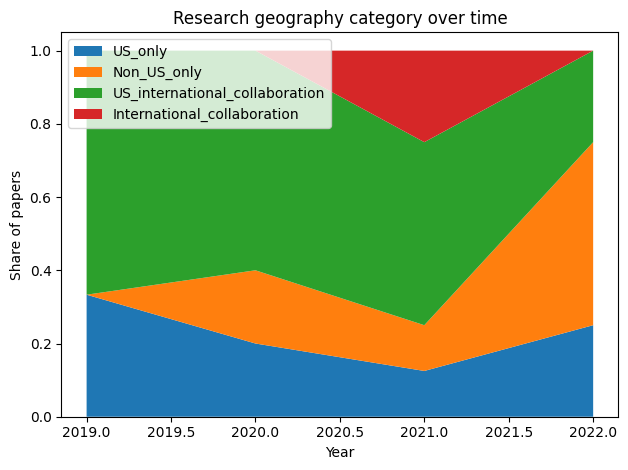

In [17]:
"""
Geography-over-time analysis script
- Input: a JSONL file produced by your pipeline (one JSON object per line)
         Each line looks like: {"<paper title>": {"affiliation_countries": "{...json string...}", "published_year": "{...json string...}", ...}}
- Output:
  1) CSV: geography_over_time.csv  (counts by year and category)
  2) CSV: geography_over_time_share.csv (shares by year and category)
  3) Optional plot: geography_over_time.png
"""

import json
import re
import csv
from collections import defaultdict, Counter
from pathlib import Path

# -------------------------
# CONFIG
# -------------------------
INPUT_JSONL_PATH = "rors_sample_paper.jsonl"     # <- change if needed
OUT_COUNTS_CSV   = "geography_over_time.csv"
OUT_SHARES_CSV   = "geography_over_time_share.csv"
OUT_PNG          = "geography_over_time.png"

# Your categories
CATS = [
    "US_only",
    "Non_US_only",
    "US_international_collaboration",
    "International_collaboration",
    "unknown",
]

# -------------------------
# Helpers
# -------------------------
def safe_json_loads_maybe(s):
    """Try parse JSON from a string; return dict or None."""
    if s is None:
        return None
    if isinstance(s, dict):
        return s
    if not isinstance(s, str):
        return None
    s = s.strip()
    if not s:
        return None
    # If the model returned fenced JSON or extra text, try to extract the first {...} block.
    if not (s.startswith("{") and s.endswith("}")):
        m = re.search(r"\{.*\}", s, flags=re.DOTALL)
        if m:
            s = m.group(0)
        else:
            return None
    try:
        return json.loads(s)
    except Exception:
        return None

def normalize_category(cat):
    """Handle cases where model returned a list like ['US_only'] or string."""
    if cat is None:
        return "unknown"
    if isinstance(cat, list) and cat:
        cat = cat[0]
    if not isinstance(cat, str):
        return "unknown"
    cat = cat.strip()
    return cat if cat in CATS else "unknown"

def parse_year_obj(year_field):
    """
    year_field may be:
    - {"year": "2020"} as dict
    - a JSON string containing {"year": "..."}
    - sometimes plain "2020"
    """
    if year_field is None:
        return None
    if isinstance(year_field, int):
        return year_field
    if isinstance(year_field, str):
        s = year_field.strip()
        # plain year like "2020"
        m = re.search(r"\b(19\d{2}|20\d{2})\b", s)
        if m:
            return int(m.group(1))
        # or JSON
        d = safe_json_loads_maybe(s)
        if d and "year" in d:
            m2 = re.search(r"\b(19\d{2}|20\d{2})\b", str(d["year"]))
            if m2:
                return int(m2.group(1))
        return None
    if isinstance(year_field, dict):
        y = year_field.get("year")
        if y is None:
            return None
        m = re.search(r"\b(19\d{2}|20\d{2})\b", str(y))
        return int(m.group(1)) if m else None
    return None

# -------------------------
# Load JSONL
# -------------------------
in_path = Path(INPUT_JSONL_PATH)
if not in_path.exists():
    raise FileNotFoundError(f"Input not found: {INPUT_JSONL_PATH}")

records = []
with in_path.open("r", encoding="utf-8") as f:
    for line_no, line in enumerate(f, start=1):
        line = line.strip()
        if not line:
            continue
        try:
            obj = json.loads(line)
        except Exception as e:
            raise ValueError(f"Bad JSON on line {line_no}: {e}") from e

        # Each line is expected to be {"paper title": {"task": "json string", ...}}
        if not isinstance(obj, dict) or len(obj) != 1:
            continue

        paper_title, tasks = next(iter(obj.items()))
        if not isinstance(tasks, dict):
            continue

        # published_year task output
        year_raw = tasks.get("published_year")
        year = parse_year_obj(year_raw)

        # affiliation_countries task output contains category too
        aff_raw = tasks.get("affiliation_countries")
        aff_obj = safe_json_loads_maybe(aff_raw) or {}
        cat = normalize_category(aff_obj.get("research_geography_category"))

        records.append({
            "paper_title": paper_title,
            "year": year,
            "research_geography_category": cat
        })

if not records:
    raise ValueError("No usable records parsed from JSONL.")

# -------------------------
# Aggregate counts by year
# -------------------------
counts = defaultdict(Counter)
for r in records:
    y = r["year"]
    cat = r["research_geography_category"]
    if y is None:
        continue
    counts[y][cat] += 1

years = sorted(counts.keys())

# Write counts CSV
with open(OUT_COUNTS_CSV, "w", newline="", encoding="utf-8") as f:
    w = csv.writer(f)
    w.writerow(["year"] + CATS)
    for y in years:
        row = [y] + [counts[y].get(c, 0) for c in CATS]
        w.writerow(row)

# Write shares CSV
with open(OUT_SHARES_CSV, "w", newline="", encoding="utf-8") as f:
    w = csv.writer(f)
    w.writerow(["year"] + CATS)
    for y in years:
        total = sum(counts[y].values()) or 1
        row = [y] + [round(counts[y].get(c, 0) / total, 6) for c in CATS]
        w.writerow(row)

print(f"Saved counts: {OUT_COUNTS_CSV}")
print(f"Saved shares: {OUT_SHARES_CSV}")

# -------------------------
# Optional plot (comment out if you don't want plotting)
# -------------------------
try:
    import matplotlib.pyplot as plt

    # Stacked area plot of shares over time (nice for trends)
    share_by_cat = {c: [] for c in CATS}
    for y in years:
        total = sum(counts[y].values()) or 1
        for c in CATS:
            share_by_cat[c].append(counts[y].get(c, 0) / total)

    x = years
    y_stack = [share_by_cat[c] for c in CATS if c != "unknown"]
    labels = [c for c in CATS if c != "unknown"]

    plt.figure()
    plt.stackplot(x, y_stack, labels=labels)
    plt.xlabel("Year")
    plt.ylabel("Share of papers")
    plt.title("Research geography category over time")
    plt.legend(loc="upper left")
    plt.tight_layout()
    plt.savefig(OUT_PNG, dpi=200)
    print(f"Saved plot: {OUT_PNG}")

except Exception as e:
    print(f"(Plot skipped) {e}")


In [19]:
"""
COMPLETE END-TO-END SCRIPT (same graphs + CSV for LaTeX)

Input:
  - rors_sample_paper.jsonl  (your pipeline output JSONL; one JSON object per line)

Outputs:
  CSVs:
    - geography_over_time_counts.csv
    - geography_over_time_shares.csv   <-- use this for LaTeX stacked bars
  Plots (PNG) in ./geo_plots/:
    - 01_stacked_area_shares.png
    - 02_multiline_shares.png
    - 03_grouped_bar_counts.png
    - 04_stacked_bar_shares.png        <-- the one you liked
    - 05_heatmap_shares.png

Notes:
- Uses matplotlib only (no seaborn).
- Does NOT set custom colors.
- Forces year ticks to be integers (no 2019.0).
- Robust to model outputs being JSON strings with extra text (tries to extract first {...}).
"""

import json
import re
import csv
from collections import defaultdict, Counter
from pathlib import Path
from typing import Dict, List, Tuple, Any, Optional

import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

# -------------------------
# CONFIG
# -------------------------
INPUT_JSONL_PATH = "rors_sample_paper.jsonl"

OUT_COUNTS_CSV = "geography_over_time_counts.csv"
OUT_SHARES_CSV = "geography_over_time_shares.csv"

OUT_DIR = "geo_plots"

CATS = [
    "US_only",
    "Non_US_only",
    "US_international_collaboration",
    "International_collaboration",
    # if you want to include unknown in your plots/CSVs, uncomment:
    # "unknown",
]


# -------------------------
# Helpers: parsing
# -------------------------
def safe_json_loads_maybe(val: Any) -> Optional[dict]:
    """Try parse JSON from dict or string; returns dict or None."""
    if val is None:
        return None
    if isinstance(val, dict):
        return val
    if not isinstance(val, str):
        return None

    s = val.strip()
    if not s:
        return None

    # If it isn't pure JSON, try to extract the first {...} block
    if not (s.startswith("{") and s.endswith("}")):
        m = re.search(r"\{.*\}", s, flags=re.DOTALL)
        if not m:
            return None
        s = m.group(0)

    try:
        return json.loads(s)
    except Exception:
        return None


def parse_year_from_published_year_field(published_year_field: Any) -> Optional[int]:
    """
    published_year task output may be:
      - JSON string: {"year":"2020"}
      - dict: {"year":"2020"}
      - plain text containing 2020
    """
    if published_year_field is None:
        return None

    if isinstance(published_year_field, dict):
        y = published_year_field.get("year")
        if y is None:
            return None
        m = re.search(r"\b(19\d{2}|20\d{2})\b", str(y))
        return int(m.group(1)) if m else None

    if isinstance(published_year_field, str):
        s = published_year_field.strip()
        # direct year in text
        m = re.search(r"\b(19\d{2}|20\d{2})\b", s)
        if m:
            return int(m.group(1))
        # JSON in string
        d = safe_json_loads_maybe(s)
        if d and "year" in d:
            m2 = re.search(r"\b(19\d{2}|20\d{2})\b", str(d["year"]))
            return int(m2.group(1)) if m2 else None
        return None

    # if it's int/float-ish
    try:
        m = re.search(r"\b(19\d{2}|20\d{2})\b", str(published_year_field))
        return int(m.group(1)) if m else None
    except Exception:
        return None


def normalize_category(cat_val: Any) -> str:
    """Category can be a string or list like ['US_only']."""
    if cat_val is None:
        return "unknown"
    if isinstance(cat_val, list) and cat_val:
        cat_val = cat_val[0]
    if not isinstance(cat_val, str):
        return "unknown"
    cat = cat_val.strip()
    return cat if cat in CATS else ("unknown" if "unknown" in CATS else CATS[0])


# -------------------------
# Load JSONL + extract minimal fields
# -------------------------
def load_records(jsonl_path: str) -> List[dict]:
    p = Path(jsonl_path)
    if not p.exists():
        raise FileNotFoundError(f"Input JSONL not found: {jsonl_path}")

    records = []
    with p.open("r", encoding="utf-8") as f:
        for line_no, line in enumerate(f, start=1):
            line = line.strip()
            if not line:
                continue
            try:
                obj = json.loads(line)
            except Exception as e:
                raise ValueError(f"Bad JSON on line {line_no}: {e}") from e

            # Expect: {"Paper Title": {"task": "response_text", ...}}
            if not isinstance(obj, dict) or len(obj) != 1:
                continue

            paper_title, tasks = next(iter(obj.items()))
            if not isinstance(tasks, dict):
                continue

            # Get year (from published_year task)
            year = parse_year_from_published_year_field(tasks.get("published_year"))

            # Get geography category (from affiliation_countries task)
            aff_raw = tasks.get("affiliation_countries")
            aff_obj = safe_json_loads_maybe(aff_raw) or {}
            cat = normalize_category(aff_obj.get("research_geography_category"))

            records.append(
                {"paper_title": paper_title, "year": year, "research_geography_category": cat}
            )
    return records


# -------------------------
# Aggregate counts + shares by year
# -------------------------
def aggregate_by_year(records: List[dict]) -> Tuple[List[int], Dict[str, List[int]], Dict[str, List[float]]]:
    counts_by_year = defaultdict(Counter)

    for r in records:
        y = r.get("year")
        cat = r.get("research_geography_category", "unknown")
        if y is None:
            continue
        if cat not in CATS:
            cat = "unknown" if "unknown" in CATS else CATS[0]
        counts_by_year[y][cat] += 1

    years = sorted(counts_by_year.keys())
    if not years:
        raise ValueError("No valid years found. Check your published_year extraction outputs.")

    # Build wide tables
    counts_wide: Dict[str, List[int]] = {c: [] for c in CATS}
    shares_wide: Dict[str, List[float]] = {c: [] for c in CATS}

    for y in years:
        total = sum(counts_by_year[y].values()) or 1
        for c in CATS:
            cnt = counts_by_year[y].get(c, 0)
            counts_wide[c].append(cnt)
            shares_wide[c].append(cnt / total)

    return years, counts_wide, shares_wide


# -------------------------
# Write CSVs (for LaTeX and general use)
# -------------------------
def write_counts_csv(path: str, years: List[int], counts: Dict[str, List[int]]):
    with open(path, "w", newline="", encoding="utf-8") as f:
        w = csv.writer(f)
        w.writerow(["Year"] + CATS)
        for i, y in enumerate(years):
            w.writerow([y] + [counts[c][i] for c in CATS])


def write_shares_csv(path: str, years: List[int], shares: Dict[str, List[float]]):
    with open(path, "w", newline="", encoding="utf-8") as f:
        w = csv.writer(f)
        w.writerow(["Year"] + CATS)
        for i, y in enumerate(years):
            w.writerow([y] + [round(shares[c][i], 6) for c in CATS])


# -------------------------
# Plot helpers
# -------------------------
def ensure_out_dir(out_dir: str):
    Path(out_dir).mkdir(parents=True, exist_ok=True)


def set_year_axis(ax, years: List[int]):
    ax.set_xticks(years)
    ax.set_xticklabels([str(y) for y in years])
    ax.xaxis.set_major_locator(mticker.FixedLocator(years))


# -------------------------
# Plots (same set as before)
# -------------------------
def plot_stacked_area_shares(years, shares, out_path):
    ys = [shares[c] for c in CATS]
    plt.figure()
    plt.stackplot(years, ys, labels=CATS)
    plt.xlabel("Year")
    plt.ylabel("Share of papers")
    plt.title("Research geography category over time (stacked area)")
    plt.legend(loc="upper left")
    set_year_axis(plt.gca(), years)
    plt.ylim(0, 1)
    plt.tight_layout()
    plt.savefig(out_path, dpi=200)
    plt.close()


def plot_multiline_shares(years, shares, out_path):
    plt.figure()
    for c in CATS:
        plt.plot(years, shares[c], marker="o", label=c)
    plt.xlabel("Year")
    plt.ylabel("Share of papers")
    plt.title("Research geography category over time (multi-line)")
    plt.legend(loc="upper left")
    set_year_axis(plt.gca(), years)
    plt.ylim(0, 1)
    plt.tight_layout()
    plt.savefig(out_path, dpi=200)
    plt.close()


def plot_grouped_bar_counts(years, counts, out_path):
    n_years = len(years)
    n_cats = len(CATS)
    x = list(range(n_years))
    width = 0.8 / n_cats

    plt.figure()
    for i, c in enumerate(CATS):
        x_i = [xi + (i - (n_cats - 1) / 2) * width for xi in x]
        plt.bar(x_i, counts[c], width=width, label=c)

    plt.xlabel("Year")
    plt.ylabel("Number of papers")
    plt.title("Research geography category over time (grouped bars, counts)")
    plt.xticks(x, [str(y) for y in years])
    plt.legend(loc="upper left")
    plt.tight_layout()
    plt.savefig(out_path, dpi=200)
    plt.close()


def plot_stacked_bar_shares(years, shares, out_path):
    plt.figure()
    bottoms = [0.0] * len(years)
    for c in CATS:
        vals = shares[c]
        plt.bar(years, vals, bottom=bottoms, label=c)
        bottoms = [b + v for b, v in zip(bottoms, vals)]

    plt.xlabel("Year")
    plt.ylabel("Share of papers")
    plt.title("Research geography category over time (stacked bars)")
    plt.legend(loc="upper left")
    set_year_axis(plt.gca(), years)
    plt.ylim(0, 1)
    plt.tight_layout()
    plt.savefig(out_path, dpi=200)
    plt.close()


def plot_heatmap_shares(years, shares, out_path):
    data = [shares[c] for c in CATS]  # rows=cats, cols=years
    plt.figure()
    ax = plt.gca()
    im = ax.imshow(data, aspect="auto")
    ax.set_yticks(range(len(CATS)))
    ax.set_yticklabels(CATS)
    ax.set_xticks(range(len(years)))
    ax.set_xticklabels([str(y) for y in years])
    ax.set_xlabel("Year")
    ax.set_title("Research geography category over time (heatmap, shares)")
    plt.colorbar(im, ax=ax, label="Share")
    plt.tight_layout()
    plt.savefig(out_path, dpi=200)
    plt.close()


# -------------------------
# Main
# -------------------------
def main():
    ensure_out_dir(OUT_DIR)

    records = load_records(INPUT_JSONL_PATH)
    if not records:
        raise ValueError("No records loaded from JSONL. Check file format and path.")

    years, counts, shares = aggregate_by_year(records)

    # CSVs (LaTeX-ready shares CSV is OUT_SHARES_CSV)
    write_counts_csv(OUT_COUNTS_CSV, years, counts)
    write_shares_csv(OUT_SHARES_CSV, years, shares)

    # Plots
    plot_stacked_area_shares(years, shares, str(Path(OUT_DIR) / "01_stacked_area_shares.png"))
    plot_multiline_shares(years, shares, str(Path(OUT_DIR) / "02_multiline_shares.png"))
    plot_grouped_bar_counts(years, counts, str(Path(OUT_DIR) / "03_grouped_bar_counts.png"))
    plot_stacked_bar_shares(years, shares, str(Path(OUT_DIR) / "04_stacked_bar_shares.png"))
    plot_heatmap_shares(years, shares, str(Path(OUT_DIR) / "05_heatmap_shares.png"))

    print("Done.")
    print(f"- Counts CSV: {OUT_COUNTS_CSV}")
    print(f"- Shares CSV (LaTeX): {OUT_SHARES_CSV}")
    print(f"- Plots directory: {Path(OUT_DIR).resolve()}")


if __name__ == "__main__":
    main()


Done.
- Counts CSV: geography_over_time_counts.csv
- Shares CSV (LaTeX): geography_over_time_shares.csv
- Plots directory: C:\Users\rooha\Desktop\RoRS Program\geo_plots


In [20]:
"""
Funding disclosure analysis by research geography

Input:
  - rors_sample_paper.jsonl

Outputs:
  - funding_specificity_by_geography_counts.csv
  - funding_specificity_by_geography_shares.csv
  - funding_specificity_stacked_bar.png

Notes:
- Descriptive only (no compliance judgments)
- Uses matplotlib only
"""

import json
import re
import csv
from collections import defaultdict, Counter
from pathlib import Path

import matplotlib.pyplot as plt

# -------------------------
# CONFIG
# -------------------------
INPUT_JSONL = "rors_sample_paper.jsonl"

OUT_COUNTS = "funding_specificity_by_geography_counts.csv"
OUT_SHARES = "funding_specificity_by_geography_shares.csv"
OUT_PLOT   = "funding_specificity_stacked_bar.png"

GEO_CATS = [
    "US_only",
    "Non_US_only",
    "US_international_collaboration",
    "International_collaboration"
]

SPEC_CATS = ["High", "Medium", "Low", "None"]

# -------------------------
# Helpers
# -------------------------
def safe_json(s):
    if s is None:
        return None
    if isinstance(s, dict):
        return s
    if not isinstance(s, str):
        return None
    m = re.search(r"\{.*\}", s, flags=re.DOTALL)
    if not m:
        return None
    try:
        return json.loads(m.group(0))
    except Exception:
        return None


# -------------------------
# Load + Extract
# -------------------------
records = []

with open(INPUT_JSONL, "r", encoding="utf-8") as f:
    for line in f:
        obj = json.loads(line)
        _, tasks = next(iter(obj.items()))

        # geography
        geo_raw = tasks.get("affiliation_countries")
        geo_obj = safe_json(geo_raw) or {}
        geo = geo_obj.get("research_geography_category")
        if isinstance(geo, list):
            geo = geo[0]
        if geo not in GEO_CATS:
            continue

        # funding specificity
        fund_raw = tasks.get("funding_specificity")
        fund_obj = safe_json(fund_raw) or {}
        spec = fund_obj.get("funding_disclosure_specificity", "None")
        if spec not in SPEC_CATS:
            spec = "None"

        records.append((geo, spec))

# -------------------------
# Aggregate
# -------------------------
counts = defaultdict(Counter)

for geo, spec in records:
    counts[geo][spec] += 1

# -------------------------
# Write COUNTS CSV
# -------------------------
with open(OUT_COUNTS, "w", newline="", encoding="utf-8") as f:
    w = csv.writer(f)
    w.writerow(["Geography"] + SPEC_CATS)
    for geo in GEO_CATS:
        w.writerow([geo] + [counts[geo].get(s, 0) for s in SPEC_CATS])

# -------------------------
# Write SHARES CSV (LaTeX)
# -------------------------
with open(OUT_SHARES, "w", newline="", encoding="utf-8") as f:
    w = csv.writer(f)
    w.writerow(["Geography"] + SPEC_CATS)
    for geo in GEO_CATS:
        total = sum(counts[geo].values()) or 1
        w.writerow([geo] + [round(counts[geo].get(s, 0)/total, 6) for s in SPEC_CATS])

# -------------------------
# Plot: Stacked Bar (Shares)
# -------------------------
fig, ax = plt.subplots()

bottom = [0]*len(GEO_CATS)
for spec in SPEC_CATS:
    values = []
    for geo in GEO_CATS:
        total = sum(counts[geo].values()) or 1
        values.append(counts[geo].get(spec, 0)/total)

    ax.bar(GEO_CATS, values, bottom=bottom, label=spec)
    bottom = [b+v for b,v in zip(bottom, values)]

ax.set_ylabel("Share of papers")
ax.set_title("Funding disclosure specificity by research geography")
ax.legend()
plt.tight_layout()
plt.savefig(OUT_PLOT, dpi=200)
plt.close()

print("Saved:")
print(f"- {OUT_COUNTS}")
print(f"- {OUT_SHARES}")
print(f"- {OUT_PLOT}")


Saved:
- funding_specificity_by_geography_counts.csv
- funding_specificity_by_geography_shares.csv
- funding_specificity_stacked_bar.png
